# **Evaluating Sentence Embedding Models for Subclustering HPC Support Tickets**

This notebook benchmarks the semantic quality of four sentence embedding models in preparation for subclustering HPC support tickets. The primary objective is to identify which model best captures the underlying meaning of issue summaries, prior to selecting or tuning any clustering algorithm.

### Candidate Sentence Embedding Models
We evaluate the following models:
- `nomic-ai/nomic-embed-text-v1.5`
- `BAAI/bge-m3`
- `sentence-transformers/all-MiniLM-L6-v2`
- `sentence-transformers/all-mpnet-base-v2`

### Evaluation Strategy
Each model is assessed using **KMeans** clustering as a consistent baseline across the two datasets:`TDX` (Purdue Team Dynamix tickets) and `Anvil` (Jira support tickets)

To determine how well each model separates and compacts similar tickets, we compute:
- **Silhouette Score** (higher = better cohesion + separation)
- **Davies-Bouldin Index (DBI)** (lower = better compactness + distinctness)

The number of clusters (*k*) used for evaluation was chosen independently for each model and dataset using elbow and silhouette visualizations (see `plot_elbow_and_silhouette`).

> **Note 1**: This analysis is focused solely on selecting the best **embedding model**. Once selected, we will use it to embed tickets **within each parent cluster** and evaluate multiple clustering algorithms to support high-quality FAQ generation.

> **Note 2**: Prior to comparison, all embeddings were normalized, as both Silhouette Score and Davies-Bouldin Index (DBI) rely on Euclidean distance. Normalization ensures that Euclidean distance approximates cosine similarity, making the metrics more meaningful for high-dimensional embeddings.

## **Imports and Setup**

In [3]:
# Data Handling
import pandas as pd
import numpy as np
from collections import defaultdict

# Embedding Models
from sentence_transformers import SentenceTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering & Evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Elbow Method
from kneed import KneeLocator  # pip install kneed

# GPU Support
import torch

# Google Colab & HuggingFace
from huggingface_hub import login

In [4]:
# Mount google drive (Colab only)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# HuggingFace login
login("") # insert token here

## **Load Embedding Models**

In [6]:
# Load models
embedding_models = {
    "nomic": SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True).to("cuda"),
    "bge-m3": SentenceTransformer('BAAI/bge-m3').to("cuda"),
    "minilm": SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to("cuda"),
    "mpnet": SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to("cuda")
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_hf_nomic_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hf_nomic_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## **Dataset Configuration**

The optimal number of clusters (*k*) for each sentence embedding model was determined by evaluating both the **elbow method** (based on inertia) and the **silhouette score** across a range of *k* values.

While the elbow method provides insight into diminishing returns in intra-cluster compactness, **silhouette scores were prioritized** for final *k* selection. This is because silhouette analysis directly reflects **both intra-cluster cohesion and inter-cluster separation**, which are critical for producing **well-defined and meaningful subclusters** in downstream FAQ generation tasks.


In [9]:
datasets = {
        'anvil': { # 677
        'path': '/content/drive/MyDrive/Colab Notebooks/TicketHub/anvil_ticket_summaries.csv',
        'best_k': {"nomic": 5, "bge-m3": 2, "minilm": 7, "mpnet": 5}
    },
    'tdx': { # 1958
        'path': '/content/drive/MyDrive/Colab Notebooks/TicketHub/tdx_ticket_summaries.csv',
        'best_k': {"nomic": 7, "bge-m3": 5, "minilm": 7, "mpnet": 10}
    }
}


## **Helper: Elbow & Silhouette Visualization**



In [18]:
# Function to compute and visualize Elbow and Silhouette curves for a given embedding model
def plot_elbow_and_silhouette(embeddings, model_name, max_k=10, show=True):
    inertias = []        # Measures cluster compactness (used for elbow method)
    silhouettes = []     # Measures cluster separation and compactness
    ks = list(range(2, max_k + 1))  # Try cluster counts from k=2 to max_k

    # Loop over candidate k values and compute clustering quality
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        inertias.append(kmeans.inertia_)  # Sum of squared distances within clusters
        labels = kmeans.labels_
        silhouettes.append(silhouette_score(embeddings, labels))  # Higher is better

    # Automatically find the 'elbow' point where adding clusters yields diminishing returns
    elbow_finder = KneeLocator(ks, inertias, curve='convex', direction='decreasing')
    elbow_k = elbow_finder.knee

    # Find the number of clusters that gives the highest silhouette score
    best_silhouette_k = ks[silhouettes.index(max(silhouettes))]

    if show:
        fig, ax1 = plt.subplots(figsize=(8, 5))

        # Plot inertia (elbow curve)
        ax1.plot(ks, inertias, 'o-', label='Inertia (Elbow)', color='tab:blue')
        ax1.set_xlabel('Number of Clusters (k)', fontweight="bold", fontsize=14)
        ax1.set_ylabel('Inertia', color='tab:blue', fontweight="bold", fontsize=14)
        ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=12)
        ax1.tick_params(axis='x', labelsize=12)
        if elbow_k:
            ax1.axvline(elbow_k, color='tab:blue', linestyle=':', label=f'Elbow @ k={elbow_k}')

        # Plot silhouette scores
        ax2 = ax1.twinx()
        ax2.plot(ks, silhouettes, 's--', label='Silhouette Score', color='tab:orange')
        ax2.set_ylabel('Silhouette Score', color='tab:orange', fontweight="bold", fontsize=14)
        ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=12)
        ax2.axvline(best_silhouette_k, color='tab:orange', linestyle=':', label=f'Silhouette Peak @ k={best_silhouette_k}')

        plt.title(f'Elbow & Silhouette Analysis: {model_name}')
        fig.tight_layout()
        fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5,-0.1), fontsize=12, frameon=False)
        plt.show()



 Processing ANVIL dataset...
Plotting for nomic


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

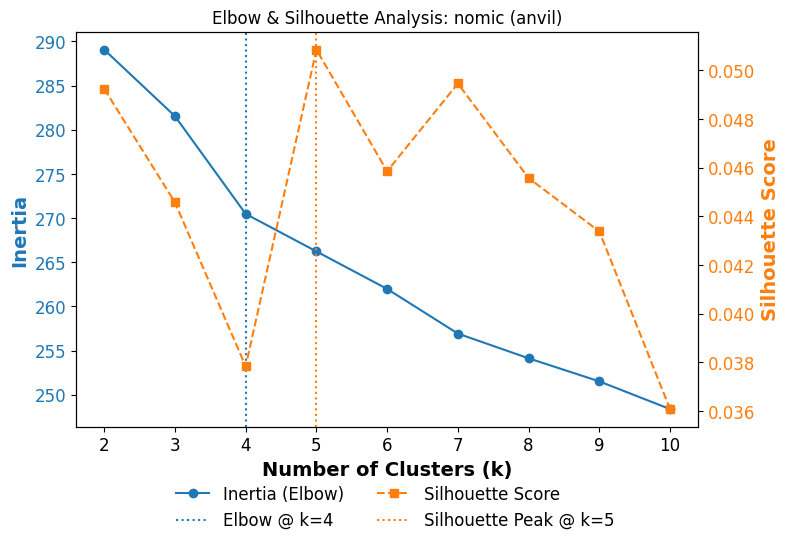

Plotting for bge-m3


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

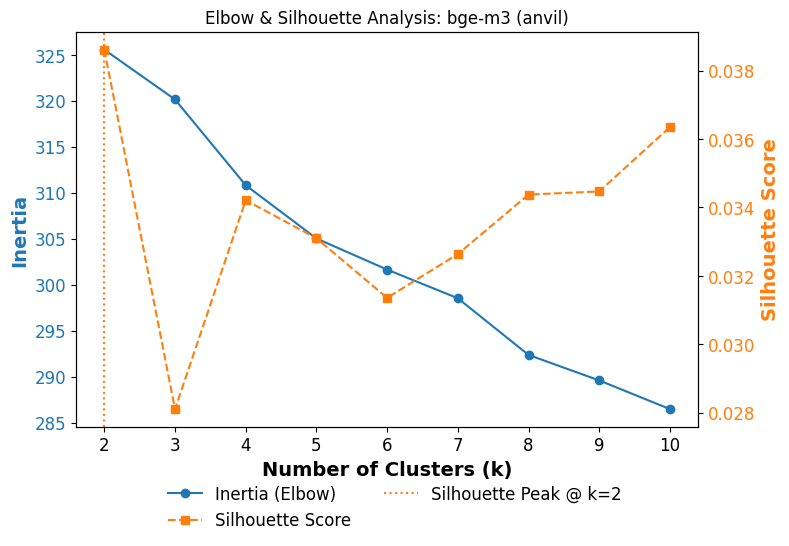

Plotting for minilm


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

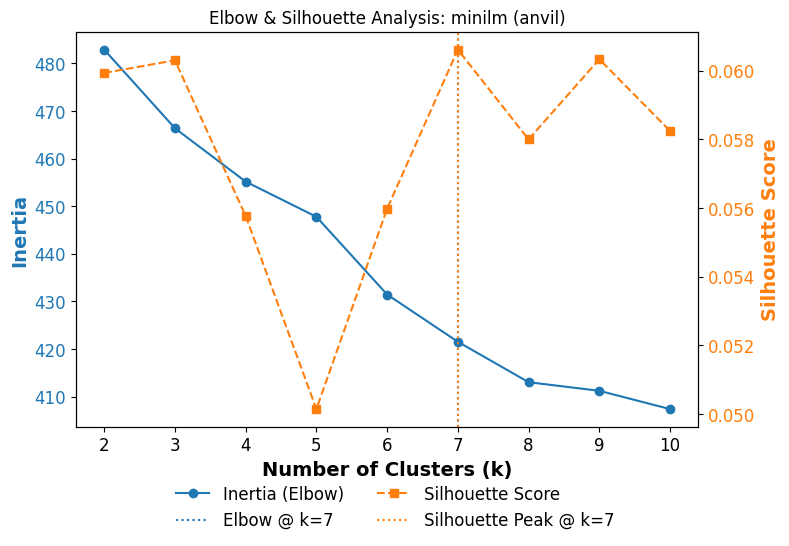

Plotting for mpnet


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

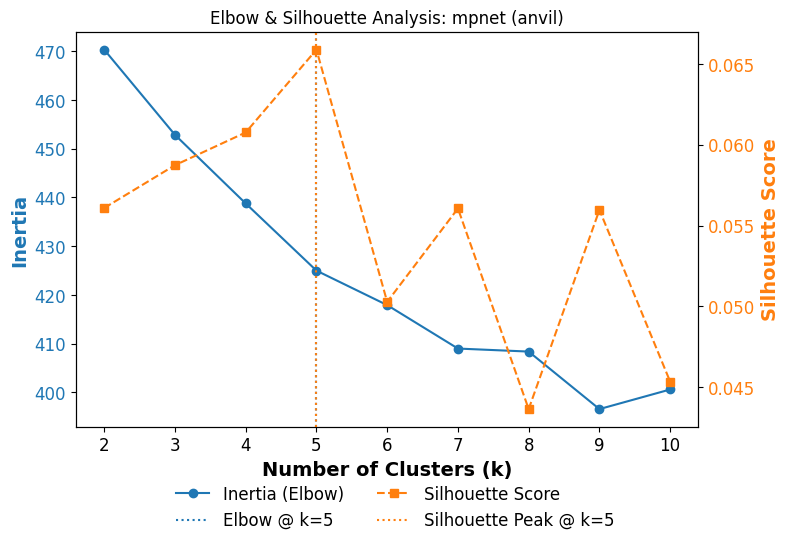


 Processing TDX dataset...
Plotting for nomic


Batches:   0%|          | 0/61 [00:00<?, ?it/s]

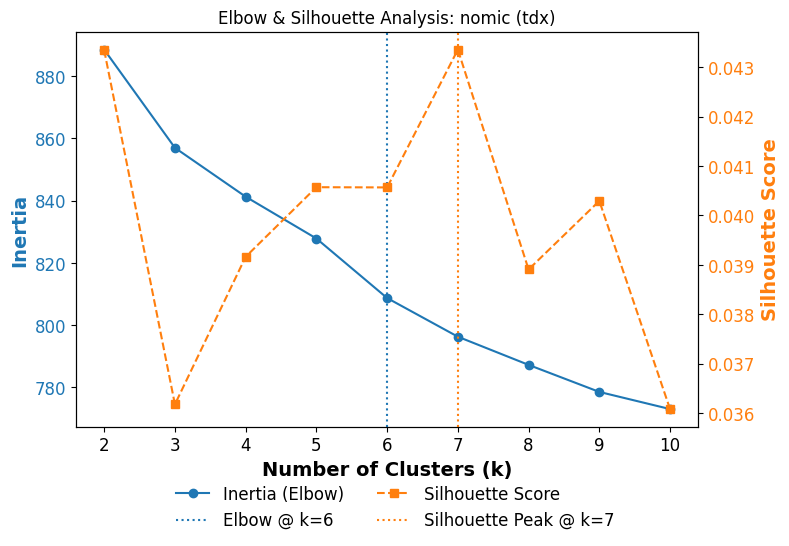

Plotting for bge-m3


Batches:   0%|          | 0/61 [00:00<?, ?it/s]

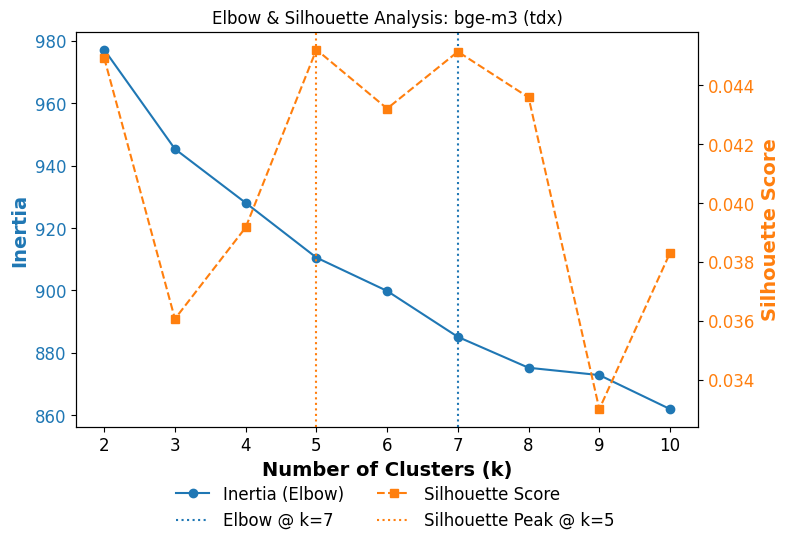

Plotting for minilm


Batches:   0%|          | 0/61 [00:00<?, ?it/s]

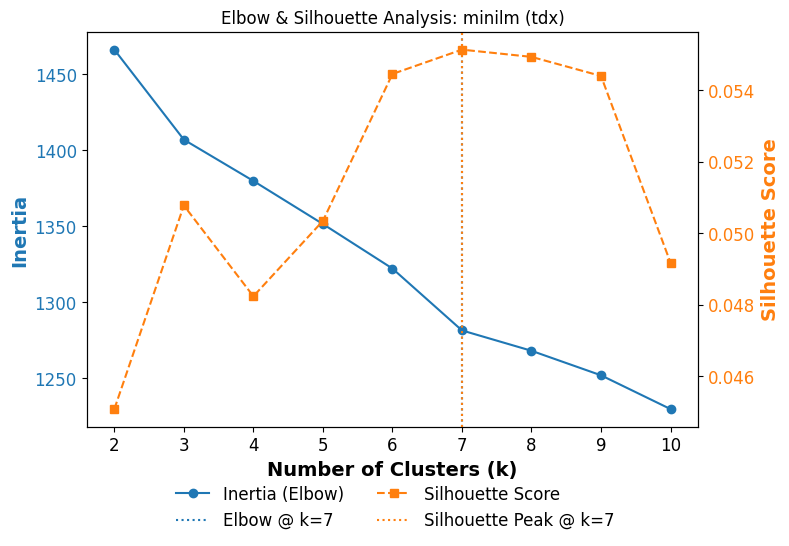

Plotting for mpnet


Batches:   0%|          | 0/61 [00:00<?, ?it/s]

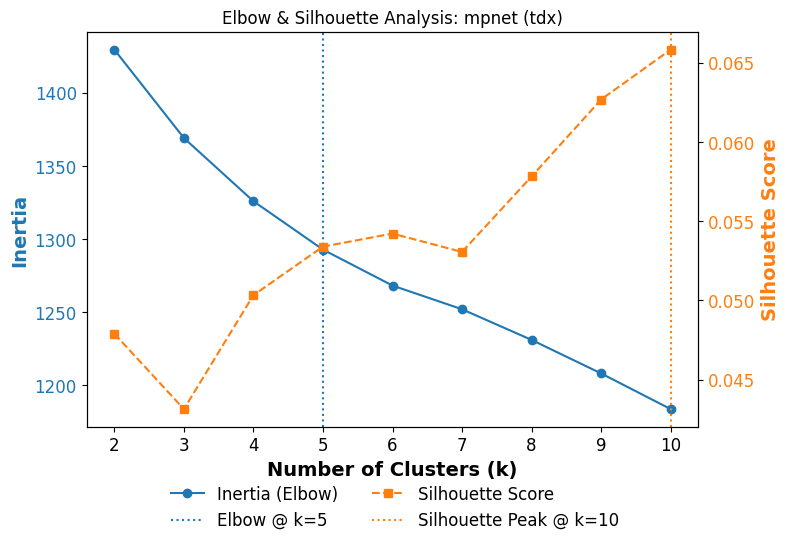

In [19]:
# Run elbow/silhouette visualizations per dataset for each embedding model
for source, config in datasets.items():
    print(f"\n Processing {source.upper()} dataset...")
    df = pd.read_csv(config['path'])
    summaries = df['issue_summary'].tolist()

    for model_name, model in embedding_models.items():
        print(f"Plotting for {model_name}")
        embeddings = model.encode(summaries, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True) # Normalize embeddings
        plot_elbow_and_silhouette(embeddings, f"{model_name} ({source})")

## **Evaluation Loop**

In [ ]:
# Dictionary to store evaluation results for each dataset (TDX and Anvil)
all_results = {}

# Loop over both datasets defined in the `datasets` dictionary
for source, config in datasets.items():
    print(f"\nProcessing {source.upper()} dataset...")

    # Load the dataset from the specified CSV path
    df = pd.read_csv(config['path'])

    # Extract the list of issue summaries to be embedded
    summaries = df['issue_summary'].tolist()

    # Initialize dictionaries to store clustering scores for this dataset
    silhouette_scores, dbi_scores = {}, {}

    # Iterate through each embedding model
    for name, model in embedding_models.items():
        print(f" - Encoding with {name}")

        # Encode the summaries using the current sentence embedding model
        embeddings = model.encode(summaries, convert_to_numpy=True, normalize_embeddings=True) # Normalize embeddings

        # Retrieve the pre-determined best number of clusters (k) for this model-dataset pair
        k = config['best_k'][name]

        # Perform KMeans clustering with the chosen k value
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        labels = kmeans.labels_

        # Compute Silhouette Score (higher is better: well-separated and tight clusters)
        silhouette_scores[name] = silhouette_score(embeddings, labels)

        # Compute Davies-Bouldin Index (lower is better: low intra-cluster variance, high inter-cluster separation)
        dbi_scores[name] = davies_bouldin_score(embeddings, labels)

        # Store the computed metrics for this dataset in hte overall results dictionary
    all_results[source] = {
        'silhouette': silhouette_scores,
        'dbi': dbi_scores
    }


Processing ANVIL dataset...
 - Encoding with nomic
 - Encoding with bge-m3
 - Encoding with minilm
 - Encoding with mpnet

Processing TDX dataset...
 - Encoding with nomic
 - Encoding with bge-m3
 - Encoding with minilm
 - Encoding with mpnet


## **Format Results**

In [ ]:
silhouette_df = pd.DataFrame({src: data['silhouette'] for src, data in all_results.items()})
dbi_df = pd.DataFrame({src: data['dbi'] for src, data in all_results.items()})

## **Plot Results**

In [ ]:
## map dataset names to custom legend labels
#dataset_label_map = {"anvil": "A", "tdx": "B"}
dataset_label_map = {"anvil": "Anvil", "tdx": "TDX"}

In [ ]:
def plot_model_comparison(metric_df, title, ylabel):
  # Extract model names (row indices) and dataset names (column labels)
    models = metric_df.index.tolist()
    datasets = metric_df.columns.tolist()

    # Define x-axis positions for the models
    x = np.arange(len(models))  # label locations
    width = 0.35  # width of bars

    # Assign a unique color per dataset
    cmap = plt.colormaps["Paired"]
    dataset_colors = {dataset: cmap(i) for i, dataset in enumerate(datasets)}

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = []

    # Plto bars for each dataset, offsetting their positions side-by-side
    for i, dataset in enumerate(datasets):
        # Compute horizontal offset for each dataset
        offset = (i - len(datasets)/2) * width + width/2
        values = metric_df[dataset].values

        # Create a bar chart for this dataset
        bar = ax.bar(x + offset, values, width, label=dataset_label_map.get(dataset, dataset),
             color=dataset_colors[dataset])
        bars.append(bar)

        # Add values on top of bars
        for rect in bar:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    # Set title and axis labels
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(models)

    # Add legend and grid
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

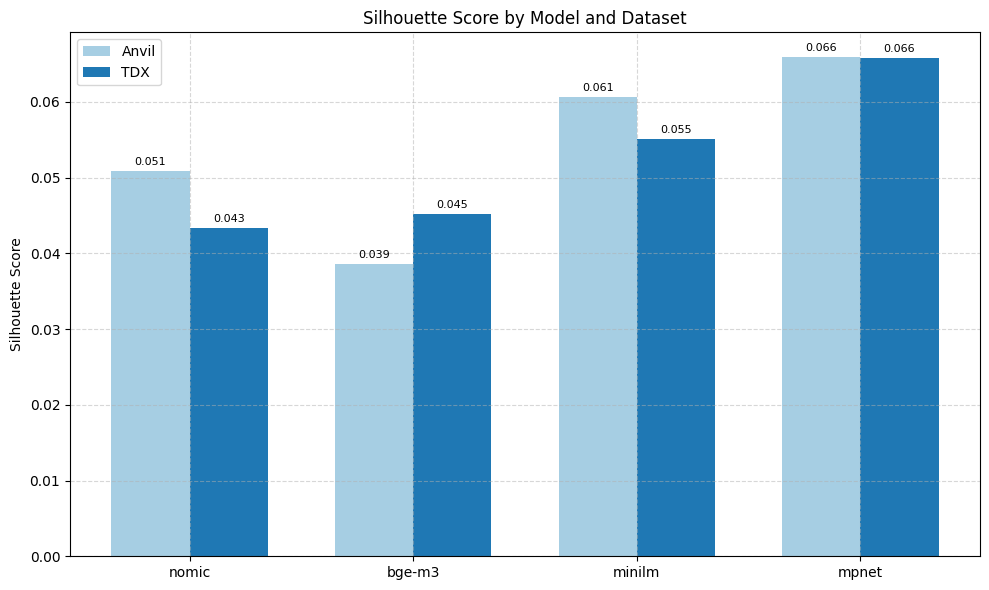

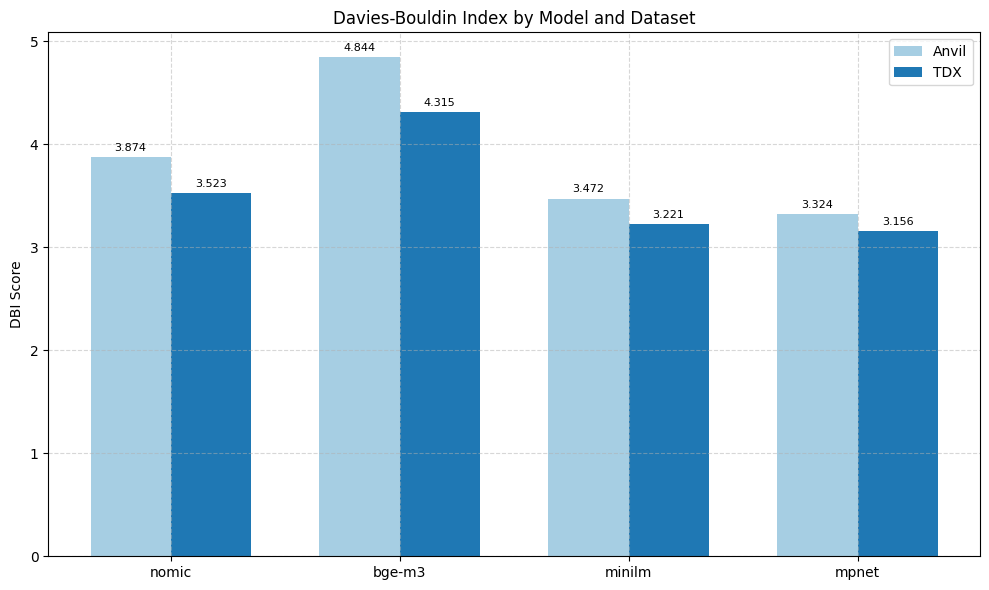

In [ ]:
# Compare results visually for the different sentence embeddings
plot_model_comparison(silhouette_df, "Silhouette Score by Model and Dataset", "Silhouette Score")
plot_model_comparison(dbi_df, "Davies-Bouldin Index by Model and Dataset", "DBI Score")


## **Model Selection Summary**

| **Model** | **Optimal k (TDX / Anvil)** | **Silhouette Score ↑ (TDX / Anvil)** | **DBI ↓ (TDX / Anvil)** |
|-----------|-----------------------------|---------------------------------------|---------------------------|
| `nomic`   | 7 / 5                       | 0.043 / 0.051                         | 3.523 / 3.874             |
| `bge-m3`  | 5 / 2                       | 0.045 / 0.039                         | 4.315 / 4.844             |
| `minilm`  | 7 / 7                       | 0.055 / 0.061                         | 3.221 / 3.472             |
| `mpnet`   | 10 / 5                      | **0.066** / **0.066**                 | **3.156** / **3.324**     |

---

### **Notes**

- `mpnet` has the **highest silhouette score** and the **lowest DBI** on **both datasets**
- `minilm` remains strong on Anvil with the **second-best DBI and silhouette**.

---

### ✅ **Recommended Model: `all-mpnet-base-v2`**

Selected for its **strong, consistent performance** across both datasets:

- Achieved **highest silhouette score (0.066)** on both Anvil and TDX.
- Delivered the **lowest DBI (3.156; 3.324)** on both Anvil and TDX.

> **Conclusion**: `all-mpnet-base-v2` offers the best trade-off between clustering quality and long-term scalability across datasets.
